In [2]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
credito = pd.read_csv('credito_projeto.csv')

In [4]:
credito.head()

,IDCREDITO,Duracao,HistoricoCredito,Proposito,Valor,Investimentos,Emprego,TempoParcelamento,EstadoCivil,FiadorTerceiros,ResidenciaDesde,Idade,OutrosFinanciamentos,Habitacao,EmprestimoExistente,Profissao,Dependentes,SocioEmpresa,Estrangeiro,Status
0,2,48,2,1,5951,2,3.0,2,1,3,2.0,22,3,1.0,1,4,1,0,0,0
1,3,12,1,2,2096,2,4.0,2,4,3,3.0,49,3,1.0,1,3,2,0,0,1
2,4,42,2,3,7882,2,4.0,2,4,4,4.0,45,3,2.0,1,4,2,0,0,1
3,5,24,3,4,4870,2,3.0,3,4,3,4.0,53,3,2.0,2,4,2,0,0,0
4,6,36,2,2,9055,1,3.0,2,4,3,4.0,35,3,2.0,1,3,2,1,0,1


In [5]:
credito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IDCREDITO             1000 non-null   int64  
 1   Duracao               1000 non-null   int64  
 2   HistoricoCredito      1000 non-null   int64  
 3   Proposito             1000 non-null   int64  
 4   Valor                 1000 non-null   int64  
 5   Investimentos         1000 non-null   int64  
 6   Emprego               990 non-null    float64
 7   TempoParcelamento     1000 non-null   int64  
 8   EstadoCivil           1000 non-null   int64  
 9   FiadorTerceiros       1000 non-null   int64  
 10  ResidenciaDesde       993 non-null    float64
 11  Idade                 1000 non-null   int64  
 12  OutrosFinanciamentos  1000 non-null   int64  
 13  Habitacao             991 non-null    float64
 14  EmprestimoExistente   1000 non-null   int64  
 15  Profissao             

In [6]:
categorical_features = [
                           "SocioEmpresa",
                           "Dependentes",
                           "Estrangeiro",
                           "Habitacao",
                           "OutrosFinanciamentos",
                           "EmprestimoExistente",
                           "ResidenciaDesde",
                           "FiadorTerceiros",
                           "TempoParcelamento",
                           "EstadoCivil",
                           "Emprego",
                           "Investimentos",
                           "Profissao",
                           "HistoricoCredito"
                       ]

numerical_features = [
                        "Proposito",
                        "Duracao",
                        "Idade",
                        "Valor"
                     ]

In [7]:
credito[categorical_features] = credito[categorical_features].astype('category')

In [8]:
credito.nunique().sort_values()

Status                     2
SocioEmpresa               2
Dependentes                2
Estrangeiro                2
Habitacao                  3
OutrosFinanciamentos       3
EmprestimoExistente        4
ResidenciaDesde            4
FiadorTerceiros            4
TempoParcelamento          4
EstadoCivil                4
Emprego                    5
Investimentos              5
Profissao                  5
HistoricoCredito           6
Proposito                 10
Duracao                   33
Idade                     53
Valor                    921
IDCREDITO               1000
dtype: int64

In [9]:
credito.groupby('Emprego')['Status'].mean()

Emprego
1.0    0.590643
2.0    0.744939
3.0    0.692308
4.0    0.773256
5.0    0.629032
Name: Status, dtype: float64

In [10]:
data = credito.groupby('Duracao')['Valor'].mean()
duration = data.index
amount = data.values

In [11]:
line1 = go.Scatter(x=duration, y=amount, mode='lines', name='Lines')

layout = go.Layout(title='Valor médio por duração do empréstimo',
                   xaxis={'title': 'Duração'},
                   yaxis={'title': 'Valor Médio'})

fig = go.Figure(data=[line1], layout=layout)
py.iplot(fig)

In [12]:
target = 'Status'

X = credito.drop([target, 'IDCREDITO',], axis=1)
y = credito[target]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

In [15]:
weights_dict

{0: 1.6736401673640167, 1: 0.7130124777183601}

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

In [17]:
numerical_transformer = Pipeline(
    [   
        ('scaler', StandardScaler()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

categorical_transformer = Pipeline(
    [   
        ('encoder', TargetEncoder()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [37]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

model = GradientBoostingClassifier(random_state=42)
model2 = RandomForestClassifier(random_state=42, class_weight=weights_dict)
meta_model = LogisticRegression(n_jobs=50, class_weight=weights_dict, random_state=42)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('select', SelectKBest(f_classif, k=15)),
        ('classifier', StackingClassifier(
            estimators=[
                ('gbc', model),
                ('rfc', model2)
            ],
            final_estimator=meta_model
        ))
    ]
)

In [38]:
help(GradientBoostingClassifier)

Help on class GradientBoostingClassifier in module sklearn.ensemble._gb:

class GradientBoostingClassifier(sklearn.base.ClassifierMixin, BaseGradientBoosting)
 |  GradientBoostingClassifier(*, loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
 |  
 |  Gradient Boosting for classification.
 |  
 |  This algorithm builds an additive model in a forward stage-wise fashion; it
 |  allows for the optimization of arbitrary differentiable loss functions. In
 |  each stage ``n_classes_`` regression trees are fit on the negative gradient
 |  of the loss function, e.g. binary or multiclass log loss. Binary
 |  classification is a special case where only a single regression

In [39]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [40]:
param_dist = {
    'classifier__gbc__n_estimators': [30, 50, 100],
    'classifier__gbc__learning_rate': [0.01, 0.1, 0.5],
    'classifier__gbc__max_depth': [2, 3, 4],

    'classifier__rfc__n_estimators': [30, 50, 100]
}

In [41]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=27, scoring='accuracy', cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['Proposito',
                                                                                'Duracao',
                                                                                'Idade',
                                                                                'Valor']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                TargetEncoder()),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['SocioE...
                                                                 final_estimator=LogisticRegression(class_weight={0: 1.6736401673640167,
                                                                                                                  1: 0.7130124777183601},
                                                                                                    n_jobs=50,
                                                                                                    random_state=42)))]),
                   n_iter=27, n_jobs=-1,
                   param_distributions={'classifier__gbc__learning_rate': [0.01,
                                                                           0.1,
                                                                           0.5],
                                        'classifier__gbc__max_depth': [2, 3, 4],
                                        'classifier__gbc__n_estimators': [30,
                                                                          50,
                                                                          100],
                                        'classifier__rfc__n_estimators': [30,
                                                                          50,
                                                                          100]},
                   scoring='accuracy')

In [43]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

In [44]:
best_params, best_estimator

({'classifier__rfc__n_estimators': 30,
  'classifier__gbc__n_estimators': 100,
  'classifier__gbc__max_depth': 3,
  'classifier__gbc__learning_rate': 0.1},
 Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler()),
                                                                   ('imputer',
                                                                    SimpleImputer(strategy='median'))]),
                                                   ['Proposito', 'Duracao',
                                                    'Idade', 'Valor']),
                                                  ('cat',
                                                   Pipeline(steps=[('encoder',
                                                                    TargetEncoder()),
                                

In [45]:
y_pred = best_estimator.predict(X_test)

In [46]:
from sklearn.metrics import (accuracy_score, precision_score, roc_auc_score, f1_score, recall_score, confusion_matrix)

print('Acurácia:', accuracy_score(y_test, y_pred))
print('ROC_AUC:', roc_auc_score(y_test, y_pred))

print()

print('Precisão:', precision_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

print()

print('Precisão p/ Não Pagadores:', precision_score(y_test, y_pred, pos_label=0))
print('F1 p/ Não Pagadores:', f1_score(y_test, y_pred, pos_label=0))
print('Recall p/ Não Pagadores:', recall_score(y_test, y_pred, pos_label=0))

confusion_matrix(y_test, y_pred)

Acurácia: 0.685
ROC_AUC: 0.6675905177497347

Precisão: 0.8114754098360656
F1: 0.7586206896551724
Recall: 0.7122302158273381

Precisão p/ Não Pagadores: 0.48717948717948717
F1 p/ Não Pagadores: 0.5467625899280575
Recall p/ Não Pagadores: 0.6229508196721312


array([[38, 23],
       [40, 99]], dtype=int64)

In [47]:
results = []

for thres in np.arange(0.05, 1, 0.05):
    y_pred_proba = (best_estimator.predict_proba(X_test)[:, 1]>thres)
    prec = precision_score(y_test, y_pred_proba)
    rec = recall_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred_proba)

    results.append((thres, prec, rec, f1, acc))

In [48]:
results_df = pd.DataFrame(results, columns=["thres", "precision", "recall", "f1", "accuracy"])
results_df

,thres,precision,recall,f1,accuracy
0,0.05,0.695000,1.000000,0.820059,0.695
1,0.10,0.695000,1.000000,0.820059,0.695
2,0.15,0.709184,1.000000,0.829851,0.715
3,0.20,0.724868,0.985612,0.835366,0.730
4,0.25,0.750000,0.949640,0.838095,0.745
5,0.30,0.738095,0.892086,0.807818,0.705
6,0.35,0.770186,0.892086,0.826667,0.740
7,0.40,0.794702,0.863309,0.827586,0.750
8,0.45,0.808511,0.820144,0.814286,0.740
9,0.50,0.811475,0.712230,0.758621,0.685


In [49]:
best_result = max(results, key=lambda x: x[4])
best_threshold, best_prec, best_rec, best_f1, best_acc = best_result

In [50]:
best_result

(0.4, 0.7947019867549668, 0.8633093525179856, 0.8275862068965516, 0.75)

In [51]:
final_prediction = (best_estimator.predict_proba(X_test)[:, 1] > best_threshold).astype(int)

In [52]:
print('Acurácia:', accuracy_score(y_test, final_prediction))
print('ROC_AUC:', roc_auc_score(y_test, final_prediction))

print()

print('Precisão:', precision_score(y_test, final_prediction))
print('F1:', f1_score(y_test, final_prediction))
print('Recall:', recall_score(y_test, final_prediction))

print()

print('Precisão p/ Não Pagadores:', precision_score(y_test, final_prediction, pos_label=0))
print('F1 p/ Não Pagadores:', f1_score(y_test, final_prediction, pos_label=0))
print('Recall p/ Não Pagadores:', recall_score(y_test, final_prediction, pos_label=0))

confusion_matrix(y_test, final_prediction)

Acurácia: 0.75
ROC_AUC: 0.6775563156032551

Precisão: 0.7947019867549668
F1: 0.8275862068965516
Recall: 0.8633093525179856

Precisão p/ Não Pagadores: 0.6122448979591837
F1 p/ Não Pagadores: 0.5454545454545455
Recall p/ Não Pagadores: 0.4918032786885246


array([[ 30,  31],
       [ 19, 120]], dtype=int64)

In [53]:
confusao = confusion_matrix(y_test, final_prediction)

In [54]:
cols = []
for i in set(credito.iloc[:, 19].values):
    cols.append(i)
print(cols)

[0, 1]


NameError: name 'plt' is not defined

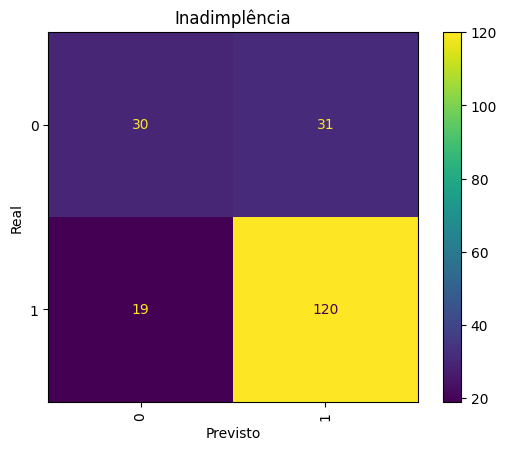

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

cmd_obj = ConfusionMatrixDisplay(confusao, display_labels=sorted(cols))
cmd_obj.plot(xticks_rotation = "vertical")
cmd_obj.ax_.set(
                title='Inadimplência',
                xlabel='Previsto',
                ylabel='Real')
plt.show()